## Visualize

In [10]:
ex_normal_dose_path = "/home/data/Datasets/Colorectal-Liver-Metastases/CRLM-CT-1028/01-22-1995-NA-CT CHABDPEL W CONTRAST-20456/2.000000-CT CAP WCONTRAST-64629/"
ex_half_path = "/home/cfigueroa/ldct_tests/ldct_sim/crlm_ld_half_gauss_poisson/CRLM-CT-1028/"
ex_forth_path = "/home/cfigueroa/ldct_tests/ldct_sim/crlm_ld_quarter_gauss_poisson/CRLM-CT-1028/"
ex_eight_path = "/home/cfigueroa/ldct_tests/ldct_sim/crlm_ld_eight_gauss_poisson/CRLM-CT-1028/"

In [11]:
import pydicom
import matplotlib.pyplot as plt
import numpy as np
import os

def get_mAs_from_ds(ds):
    """
    Obtiene mAs desde tags estándar si es posible.
    """
    # Caso 2: calcular mAs = mA * tiempo
    if hasattr(ds, "XRayTubeCurrent") and hasattr(ds, "ExposureTime"):
        mA = float(ds.XRayTubeCurrent)
        t_ms = float(ds.ExposureTime)       # ms
        return mA * (t_ms / 1000.0)         # convertir a segundos

    return None


def load_dicom_series(folder_path):
    files = [os.path.join(folder_path, f) for f in os.listdir(folder_path)
             if f.lower().endswith('.dcm') or f.isdigit()]

    datasets = [pydicom.dcmread(f) for f in files]

    # Orden seguro
    datasets.sort(key=lambda x: int(getattr(x, "InstanceNumber", 0)))

    volume = np.stack([ds.pixel_array for ds in datasets], axis=0)

    return datasets, volume


def visualize_slices(normal_dir, half_dir, forth_dir, eight_dir, slice_index=None):
    # ---- Cargar volúmenes y datasets ----
    normal_ds, normal_vol = load_dicom_series(normal_dir)
    half_ds, half_vol = load_dicom_series(half_dir)
    forth_ds, forth_vol = load_dicom_series(forth_dir)
    eight_ds, eight_vol = load_dicom_series(eight_dir)

    # ---- Obtener mAs original desde el primer DICOM ----
    mAs_normal = get_mAs_from_ds(normal_ds[0])

    # Si no se obtiene → aviso
    if mAs_normal is None:
        mAs_normal = 0
        print("No se pudo obtener mAs del estudio normal. Usando 0 como referencia.")

    # ---- mAs esperados para otras dosis ----
    mAs_half  = mAs_normal / 2
    mAs_forth = mAs_normal / 4
    mAs_eight = mAs_normal / 8

    # ---- Slice por defecto ----
    if slice_index is None:
        slice_index = normal_vol.shape[0] // 2

    # ---- Visualización ----
    fig, axs = plt.subplots(1, 4, figsize=(22, 6))

    axs[0].imshow(normal_vol[slice_index], cmap='gray')
    axs[0].set_title(f'Normal Dose\n{mAs_normal:.1f} mAs')

    axs[1].imshow(half_vol[slice_index], cmap='gray')
    axs[1].set_title(f'Half Dose\n{mAs_half:.1f} mAs')

    axs[2].imshow(forth_vol[slice_index], cmap='gray')
    axs[2].set_title(f'Quarter Dose\n{mAs_forth:.1f} mAs')

    axs[3].imshow(eight_vol[slice_index], cmap='gray')
    axs[3].set_title(f'Eighth Dose\n{mAs_eight:.1f} mAs')

    for ax in axs:
        ax.axis('off')

    plt.tight_layout()
    plt.show()

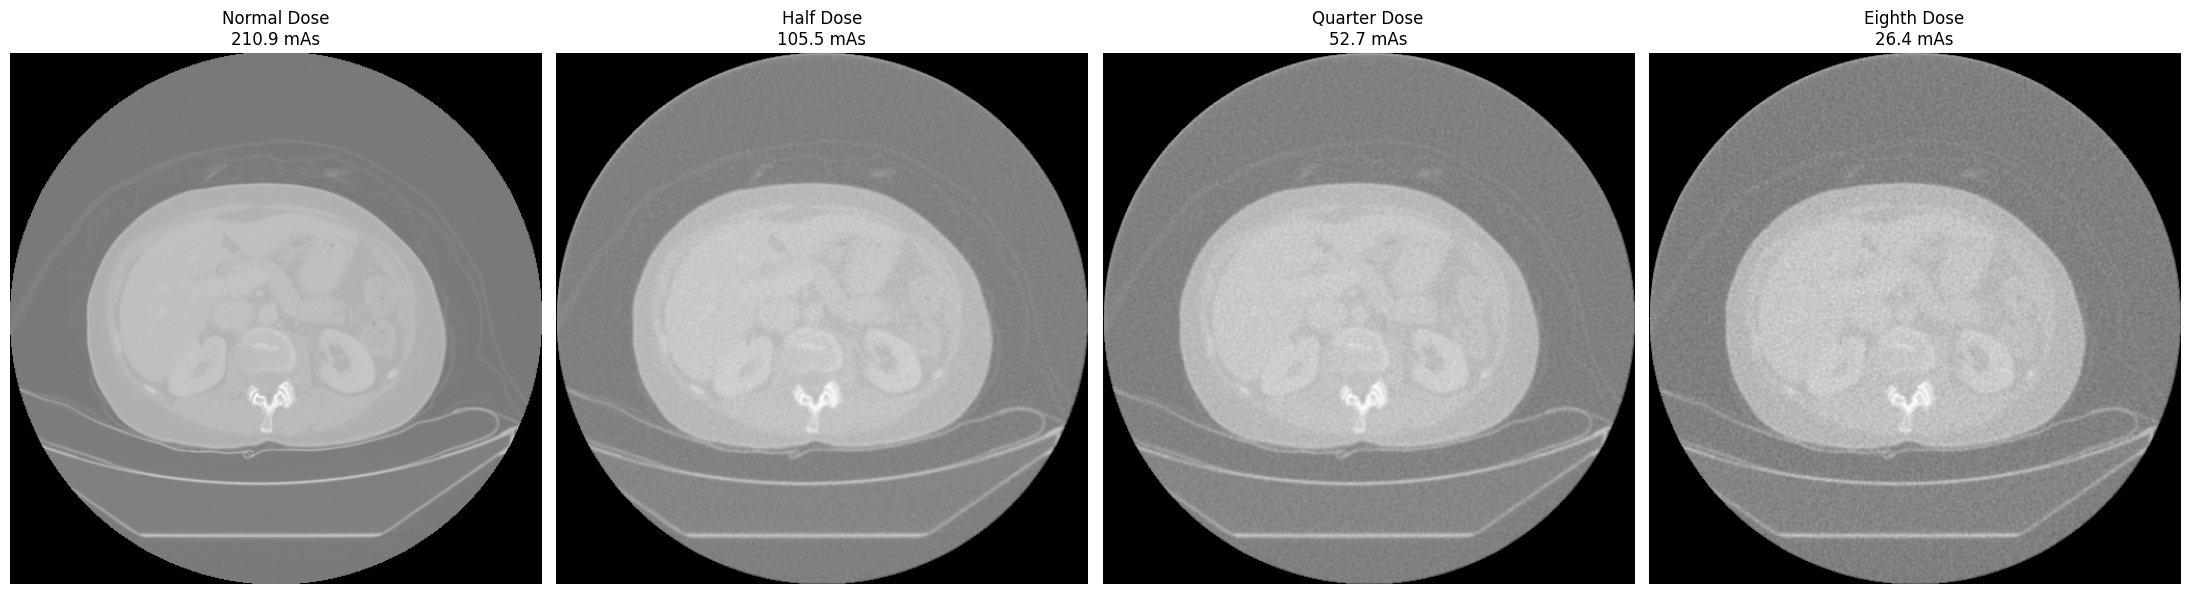

In [12]:
visualize_slices(ex_normal_dose_path, ex_half_path, ex_forth_path, ex_eight_path)

In [13]:
ex_normal_dose_path2 = "/home/data/Datasets/Colorectal-Liver-Metastases/CRLM-CT-1115/06-03-1991-NA-CT ABPEL W CONTRAST-01639/2.000000-ABDOMENPELVIS-53158/"
ex_half_path2 = "/home/cfigueroa/ldct_tests/ldct_sim/crlm_ld_half_gauss_poisson/CRLM-CT-1115/"
ex_forth_path2 = "/home/cfigueroa/ldct_tests/ldct_sim/crlm_ld_quarter_gauss_poisson/CRLM-CT-1115/"
ex_eight_path2 = "/home/cfigueroa/ldct_tests/ldct_sim/crlm_ld_eight_gauss_poisson/CRLM-CT-1115/"

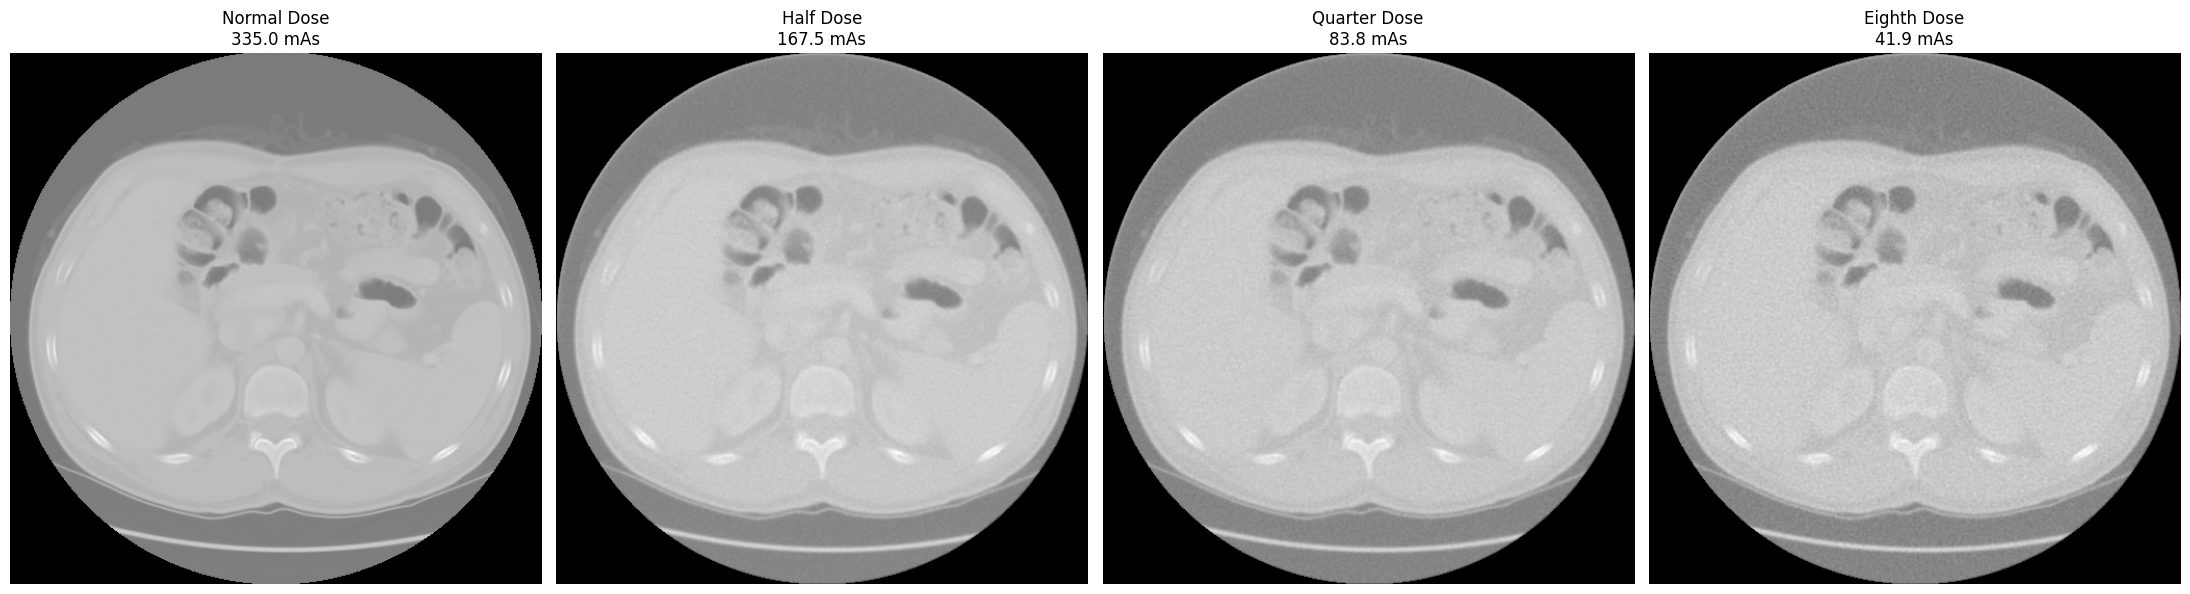

In [14]:
visualize_slices(ex_normal_dose_path2, ex_half_path2, ex_forth_path2, ex_eight_path2)

In [15]:
ex_normal_dose_path3 = "/home/data/Datasets/Colorectal-Liver-Metastases/CRLM-CT-1084/11-21-1994-NA-CT CHABDPEL W CONTRAST-61890/2.000000-CHABDPEL 5X5-24580/"
ex_half_path3 = "/home/cfigueroa/ldct_tests/ldct_sim/crlm_ld_half_gauss_poisson/CRLM-CT-1084/"
ex_forth_path3 = "/home/cfigueroa/ldct_tests/ldct_sim/crlm_ld_quarter_gauss_poisson/CRLM-CT-1084/"
ex_eight_path3 = "/home/cfigueroa/ldct_tests/ldct_sim/crlm_ld_eight_gauss_poisson/CRLM-CT-1084/"

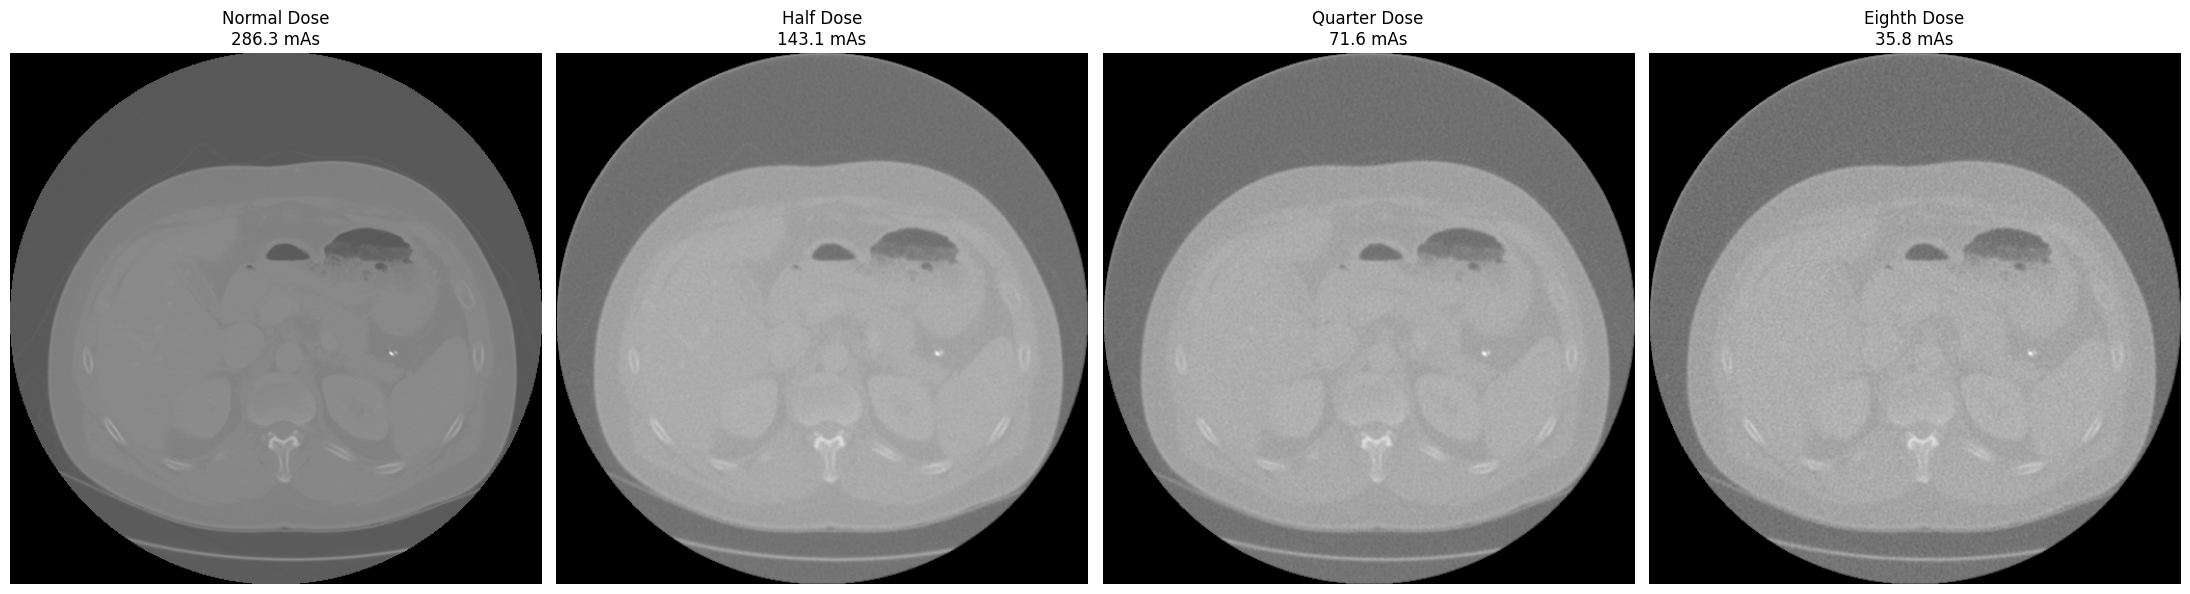

In [16]:
visualize_slices(ex_normal_dose_path3, ex_half_path3, ex_forth_path3, ex_eight_path3)

## Tumor Segmentation

#### Problema: Se observa que las segmentaciones del tumor no son adecuadas

Comparando visualmente las segmentaciones obtenidas para las de baja dosis y las imágenes reales, no tiene sentido la segmentación

In [17]:
from totalsegmentator.python_api import totalsegmentator

In [18]:
device = 'gpu:2'

In [19]:
tumor_seg_nor = totalsegmentator(ex_normal_dose_path3, task= "liver_vessels", device=device, quiet=True)

/home/cfigueroa/.venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [20]:
tumor_seg_tot = tumor_seg_nor.get_fdata()

In [21]:
import numpy as np
import matplotlib.pyplot as plt

In [22]:
np.unique(tumor_seg_tot)

array([0., 1., 2.])

In [23]:
tumor_seg_tot.shape

(512, 512, 47)

In [32]:
import numpy as np

def get_slices_with_segmentation(seg_volume, axis=2, classes=(1, 2)):
    """
    Retorna los índices de las slices que contienen segmentación.

    Parameters
    ----------
    seg_volume : np.ndarray
        Volumen 3D de segmentación (X, Y, Z)
    axis : int
        Eje que representa las slices (default=2 → axial)
    classes : tuple
        Clases de interés (default=(1,2) vessels + tumor)

    Returns
    -------
    slices_idx : list
        Lista con los índices de las slices que contienen segmentación
    """
    slices_idx = []

    for i in range(seg_volume.shape[axis]):
        if axis == 0:
            slc = seg_volume[i, :, :]
        elif axis == 1:
            slc = seg_volume[:, i, :]
        elif axis == 2:
            slc = seg_volume[:, :, i]
        else:
            raise ValueError("axis debe ser 0, 1 o 2")

        # Verifica si existe al menos un voxel de las clases deseadas
        if np.isin(slc, classes).any():
            slices_idx.append(i)

    return slices_idx


In [35]:
slices_with_seg = get_slices_with_segmentation(tumor_seg_tot, classes=(2,))

print(f"Número de slices con segmentación: {len(slices_with_seg)}")
print("Slices:", slices_with_seg)

Número de slices con segmentación: 6
Slices: [12, 13, 33, 35, 38, 39]


In [25]:
%matplotlib inline

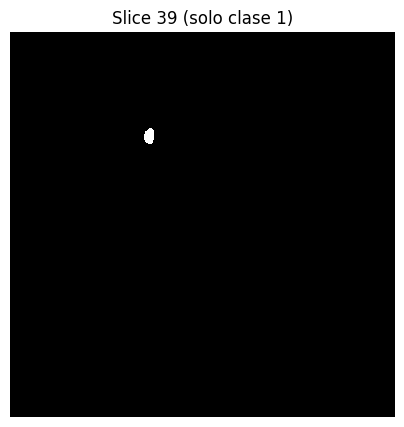

In [41]:
slice_idx = 39

# Mantener solo clase 1, todo lo demás a 0
img_bin = (tumor_seg_tot[:, :, slice_idx] == 2).astype(np.uint8)

plt.figure(figsize=(5, 5))
plt.imshow(img_bin, cmap='gray', interpolation='nearest')
plt.title(f"Slice {slice_idx} (solo clase 1)")
plt.axis("off")
plt.show()

In [58]:
from totalsegmentator.map_to_binary import class_map
print("liver_vessels" in class_map)

True


In [76]:
tumor_seg_half = totalsegmentator(ex_half_path3, task="liver_vessels", device=device, quiet=True)
tumor_seg_half = tumor_seg_half.get_fdata()

In [78]:
np.unique(tumor_seg_half)

array([0., 1., 2.])

In [79]:
ex_half_dcm = "/home/cfigueroa/ldct_tests/ldct_sim/crlm_ld_half_gauss_poisson/CRLM-CT-1084/LD2_1-05.dcm"

In [80]:
array_dcm = pydicom.dcmread(ex_half_dcm).pixel_array

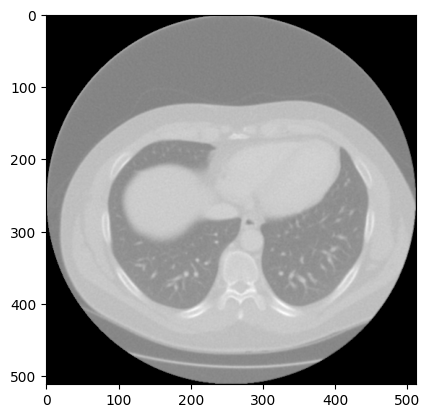

In [81]:
plt.imshow(array_dcm, cmap='gray')

In [ ]:
slices_with_seg_half = get_slices_with_segmentation(tumor_seg_half, classes=(2))

print(f"Número de slices con segmentación: {len(slices_with_seg_half)}")
print("Slices:", slices_with_seg_half)

Número de slices con segmentación: 47
Slices: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46]


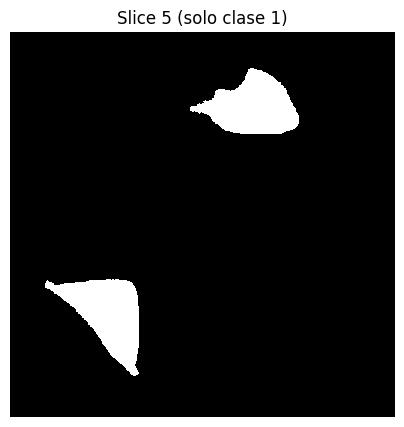

In [84]:
slice_idx = 5

# Mantener solo clase 1, todo lo demás a 0
img_bin = (tumor_seg_half[:, :, slice_idx] == 2).astype(np.uint8)

plt.figure(figsize=(5, 5))
plt.imshow(img_bin, cmap='gray', interpolation='nearest')
plt.title(f"Slice {slice_idx} (solo clase 1)")
plt.axis("off")
plt.show()

In [85]:
tumor_seg_forth = totalsegmentator(ex_forth_path3, task="liver_vessels", device=device, quiet=True)
tumor_seg_forth = tumor_seg_forth.get_fdata()

In [86]:
np.unique(tumor_seg_forth)

array([0., 1., 2.])

In [87]:
slices_with_seg_forth = get_slices_with_segmentation(tumor_seg_forth, classes=(2))

print(f"Número de slices con segmentación: {len(slices_with_seg_forth)}")
print("Slices:", slices_with_seg_forth)

Número de slices con segmentación: 46
Slices: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46]


In [88]:
tumor_seg_eight = totalsegmentator(ex_eight_path3, task="liver_vessels", device=device, quiet=True)
tumor_seg_eight = tumor_seg_eight.get_fdata()

In [89]:
np.unique(tumor_seg_eight)

array([0., 1., 2.])

In [90]:
slices_with_seg_eight = get_slices_with_segmentation(tumor_seg_eight, classes=(2))

print(f"Número de slices con segmentación: {len(slices_with_seg_eight)}")
print("Slices:", slices_with_seg_eight)

Número de slices con segmentación: 47
Slices: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46]


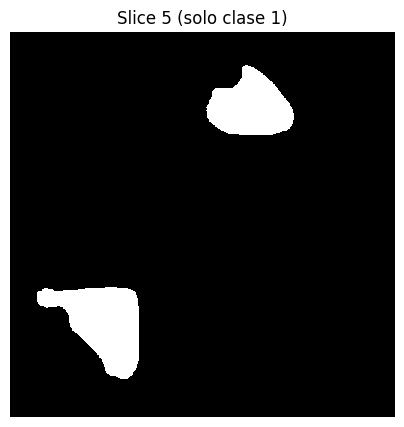

In [91]:
slice_idx = 5

# Mantener solo clase 1, todo lo demás a 0
img_bin = (tumor_seg_eight[:, :, slice_idx] == 2).astype(np.uint8)

plt.figure(figsize=(5, 5))
plt.imshow(img_bin, cmap='gray', interpolation='nearest')
plt.title(f"Slice {slice_idx} (solo clase 1)")
plt.axis("off")
plt.show()

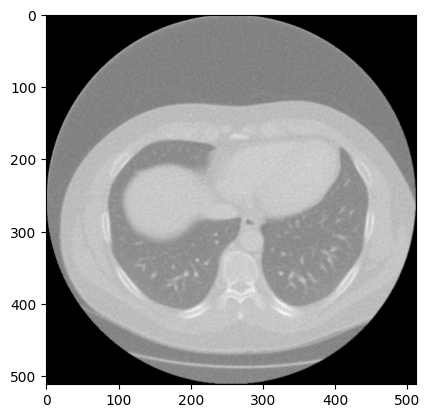

In [93]:
ex_eight_dcm = "/home/cfigueroa/ldct_tests/ldct_sim/crlm_ld_eight_gauss_poisson/CRLM-CT-1084/LD8_1-05.dcm"
array_dcm = pydicom.dcmread(ex_eight_dcm).pixel_array
plt.imshow(array_dcm, cmap='gray')

### Calcular y comparar métricas

Para esto se utilizan funciones que permiten que todas las segmentaciones estén en la dirección y sentido correctos (LPS). Esto se realizó porque no habian coincidencias en muchas de las segmentaciones con la máscara real de tumor.

##### NO OBSTANTE: el error parece deberse al problema detectado en la sección anterior. OJO

In [42]:
def iou_score(y_pred, y_true):
    """
    Binary iou score.
    """
    intersect = np.sum(y_true * y_pred)
    denominator = np.sum(y_true) + np.sum(y_pred) - intersect
    iou = (intersect) / (denominator + 1e-6)
    return iou

def dice_score(y_pred, y_true):
    """
    Binary Dice score. Same results as sklearn f1 binary.
    """
    intersect = np.sum(y_true * y_pred)
    denominator = np.sum(y_true) + np.sum(y_pred) 
    f1 = (2 * intersect) / (denominator + 1e-6)
    return f1

In [49]:
normal_dose_path = "/home/data/Datasets/Colorectal-Liver-Metastases/"
half_path = "/home/cfigueroa/ldct_tests/ldct_sim/crlm_ld_half_poisson/"
forth_path = "/home/cfigueroa/ldct_tests/ldct_sim/crlm_ld_quarter_poisson/"
eight_path = "/home/cfigueroa/ldct_tests/ldct_sim/crlm_ld_eight_poisson/"

In [50]:
import os
import pydicom
import numpy as np

def map_ct_slices(ct_folder):
    """
    Devuelve:
    - ct_volume: (Z, H, W)
    - sopuid_to_idx: dict SOPInstanceUID -> slice_idx
    """
    ct_slices = []
    for f in os.listdir(ct_folder):
        ds = pydicom.dcmread(os.path.join(ct_folder, f))
        if hasattr(ds, "ImagePositionPatient"):
            ct_slices.append(ds)

    # ordenar por eje Z
    ct_slices.sort(key=lambda x: x.ImagePositionPatient[2])

    sopuid_to_idx = {
        ds.SOPInstanceUID: idx
        for idx, ds in enumerate(ct_slices)
    }

    ct_volume = np.stack([ds.pixel_array for ds in ct_slices], axis=0)

    return ct_volume, sopuid_to_idx

def build_full_volume_from_dicomseg(dcm_seg, sopuid_to_idx, ct_shape, keyword="Tumor"):
    """
    Devuelve lista de volúmenes (Z,H,W), uno por tumor
    """
    segment_seq = dcm_seg.SegmentSequence
    per_frame_info = dcm_seg.PerFrameFunctionalGroupsSequence

    Z, H, W = ct_shape
    segment_volumes = {}

    for frame_idx, frame_info in enumerate(per_frame_info):
        seg_num = frame_info.SegmentIdentificationSequence[0].ReferencedSegmentNumber
        seg_label = segment_seq[seg_num - 1].SegmentLabel

        if keyword.lower() not in seg_label.lower():
            continue

        # UID del slice original
        src_uid = (
            frame_info
            .DerivationImageSequence[0]
            .SourceImageSequence[0]
            .ReferencedSOPInstanceUID
        )

        if src_uid not in sopuid_to_idx:
            continue

        z_idx = sopuid_to_idx[src_uid]

        if seg_num not in segment_volumes:
            segment_volumes[seg_num] = np.zeros((Z, H, W), dtype=np.uint8)

        segment_volumes[seg_num][z_idx] = dcm_seg.pixel_array[frame_idx]

    return list(segment_volumes.values())


In [51]:
import csv
import os
import numpy as np
import pydicom

results = []   


In [52]:
def center_of_mass(mask):
    coords = np.array(np.where(mask > 0))
    return coords.mean(axis=1)

In [53]:
import SimpleITK as sitk
import numpy as np

def read_dicom_series(dicom_dir):
    reader = sitk.ImageSeriesReader()
    series_ids = reader.GetGDCMSeriesIDs(dicom_dir)
    if not series_ids:
        raise RuntimeError(f"No DICOM series in {dicom_dir}")
    files = reader.GetGDCMSeriesFileNames(dicom_dir, series_ids[0])
    reader.SetFileNames(files)
    return reader.Execute()

def ras_to_lps(img):
    direction = np.array(img.GetDirection()).reshape(3, 3)
    direction[0, :] *= -1
    direction[1, :] *= -1

    origin = list(img.GetOrigin())
    origin[0] *= -1
    origin[1] *= -1

    img.SetDirection(direction.flatten())
    img.SetOrigin(origin)
    return img

def resample_to_reference(moving, reference):
    resampler = sitk.ResampleImageFilter()
    resampler.SetReferenceImage(reference)
    resampler.SetInterpolator(sitk.sitkNearestNeighbor)
    resampler.SetTransform(sitk.Transform())
    resampler.SetDefaultPixelValue(0)
    return resampler.Execute(moving)


In [ ]:
for patient_id in os.listdir(half_path):
    print(f"\nProcessing patient: {patient_id}")
    # =========================
    # Paths normal dose
    # =========================
    ex_normal_dose_path1 = os.path.join(normal_dose_path, patient_id)
    list_normal = os.listdir(ex_normal_dose_path1)
    ex_normal_dose_path2 = os.path.join(ex_normal_dose_path1, list_normal[0])
    list_normal2 = os.listdir(ex_normal_dose_path2)

    seg_path = None
    ex_normal_dose_path = None

    for subdir in list_normal2:
        if "Segmentation" in subdir:
            seg_path = os.path.join(ex_normal_dose_path2, subdir, "1-1.dcm")
        else:
            ex_normal_dose_path = os.path.join(ex_normal_dose_path2, subdir)

    if seg_path is None or ex_normal_dose_path is None:
        print(f"Missing CT or SEG for patient {patient_id}, skipping.")
        continue

    # =========================
    # Other dose paths
    # =========================
    ex_half_path = os.path.join(half_path, patient_id)
    ex_forth_path = os.path.join(forth_path, patient_id)
    ex_eight_path = os.path.join(eight_path, patient_id)

    # =========================
    # TotalSegmentator
    # =========================
    tumor_seg_nor = totalsegmentator(ex_normal_dose_path, task="liver_vessels", device=device, quiet=True)
    tumor_seg_half = totalsegmentator(ex_half_path, task="liver_vessels", device=device, quiet=True)
    tumor_seg_forth = totalsegmentator(ex_forth_path, task="liver_vessels", device=device, quiet=True)
    tumor_seg_eight = totalsegmentator(ex_eight_path, task="liver_vessels", device=device, quiet=True)

    # =========================
    # TotalSegmentator
    # =========================
    ts_results = {
        "Normal Dose": tumor_seg_nor,
        "Half Dose": tumor_seg_half,
        "Quarter Dose": tumor_seg_forth,
        "Eighth Dose": tumor_seg_eight,
    }

    # =========================
    # CT reference (LPS)
    # =========================
    ct_sitk = read_dicom_series(ex_normal_dose_path)

    # =========================
    # Ground Truth (DICOM-SEG → LPS)
    # =========================
    ct_volume, sopuid_to_idx = map_ct_slices(ex_normal_dose_path)
    dcm_seg = pydicom.dcmread(seg_path)

    seg_tumor = build_full_volume_from_dicomseg(
        dcm_seg, sopuid_to_idx, ct_volume.shape, keyword="Tumor"
    )

    if len(seg_tumor) == 0:
        print("No tumor found, skipping.")
        continue

    gt_np = np.logical_or.reduce(seg_tumor).astype(np.uint8)

    gt_sitk = sitk.GetImageFromArray(gt_np)
    gt_sitk.CopyInformation(ct_sitk)

    print("Voxels tumor GT:", gt_np.sum())
    print("GT COM:", center_of_mass(gt_np))

    # =========================
    # Predictions → LPS → resample → metrics
    # =========================
    for dose, ts_img in ts_results.items():

        seg = ts_img.get_fdata()        # (X,Y,Z)
        bin_seg = (seg == 2).astype(np.uint8)

        print(f"{dose} Pred voxels 1:", bin_seg.sum())

        pred_sitk = sitk.GetImageFromArray(
            np.transpose(bin_seg, (2, 1, 0))
        )

        print(f"{dose} Pred voxels 2:", sitk.GetArrayFromImage(pred_sitk).sum())

        # CLAVE
        pred_sitk.CopyInformation(ct_sitk)

        pred_resampled = resample_to_reference(pred_sitk, gt_sitk)
        pred_np = sitk.GetArrayFromImage(pred_resampled)

        print(f"{dose} Pred voxels 3:", pred_np.sum())
        print(f"{dose} Pred COM:", center_of_mass(pred_np))

        iou = iou_score(pred_np, gt_np)
        dice = dice_score(pred_np, gt_np)

        print(f"{dose} - IoU: {iou:.4f}, Dice: {dice:.4f}")

        results.append([
            patient_id,
            dose,
            round(iou, 4),
            round(dice, 4)
        ])



Processing patient: CRLM-CT-1004
Voxels tumor GT: 473
GT COM: [ 17.82029598 267.22832981 158.49471459]
Normal Dose Pred voxels 1: 521
Normal Dose Pred voxels 2: 521
Normal Dose Pred voxels 3: 521
Normal Dose Pred COM: [ 17.4452975  248.83685221 163.00383877]
Normal Dose - IoU: 0.2793, Dice: 0.4366
Half Dose Pred voxels 1: 0
Half Dose Pred voxels 2: 0
Half Dose Pred voxels 3: 0
Half Dose Pred COM: [nan nan nan]
Half Dose - IoU: 0.0000, Dice: 0.0000
Quarter Dose Pred voxels 1: 0
Quarter Dose Pred voxels 2: 0
Quarter Dose Pred voxels 3: 0
Quarter Dose Pred COM: [nan nan nan]


/tmp/ipykernel_299335/248075012.py:3: RuntimeWarning: Mean of empty slice.
  return coords.mean(axis=1)
/home/cfigueroa/.venv/lib/python3.10/site-packages/numpy/core/_methods.py:121: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


Quarter Dose - IoU: 0.0000, Dice: 0.0000
Eighth Dose Pred voxels 1: 0
Eighth Dose Pred voxels 2: 0
Eighth Dose Pred voxels 3: 0
Eighth Dose Pred COM: [nan nan nan]
Eighth Dose - IoU: 0.0000, Dice: 0.0000

Processing patient: CRLM-CT-1007


KeyboardInterrupt: 

In [ ]:
for patient_id in os.listdir(half_path):
    print(f"\nProcessing patient: {patient_id}")
    # =========================
    # Paths normal dose
    # =========================
    ex_normal_dose_path1 = os.path.join(normal_dose_path, patient_id)
    list_normal = os.listdir(ex_normal_dose_path1)
    ex_normal_dose_path2 = os.path.join(ex_normal_dose_path1, list_normal[0])
    list_normal2 = os.listdir(ex_normal_dose_path2)

    seg_path = None
    ex_normal_dose_path = None

    for subdir in list_normal2:
        if "Segmentation" in subdir:
            seg_path = os.path.join(ex_normal_dose_path2, subdir, "1-1.dcm")
        else:
            ex_normal_dose_path = os.path.join(ex_normal_dose_path2, subdir)

    if seg_path is None or ex_normal_dose_path is None:
        print(f"Missing CT or SEG for patient {patient_id}, skipping.")
        continue

    # =========================
    # Other dose paths
    # =========================
    ex_half_path = os.path.join(half_path, patient_id)
    ex_forth_path = os.path.join(forth_path, patient_id)
    ex_eight_path = os.path.join(eight_path, patient_id)

    # =========================
    # TotalSegmentator
    # =========================
    tumor_seg_nor = totalsegmentator(ex_normal_dose_path, task="liver_vessels", device=device, quiet=True)
    tumor_seg_half = totalsegmentator(ex_half_path, task="liver_vessels", device=device, quiet=True)
    tumor_seg_forth = totalsegmentator(ex_forth_path, task="liver_vessels", device=device, quiet=True)
    tumor_seg_eight = totalsegmentator(ex_eight_path, task="liver_vessels", device=device, quiet=True)

    seg_nor = tumor_seg_nor.get_fdata()
    seg_half = tumor_seg_half.get_fdata()
    seg_forth = tumor_seg_forth.get_fdata()
    seg_eight = tumor_seg_eight.get_fdata()

    # Transpose to (Z, H, W) to be consistent
    seg_nor = np.transpose(seg_nor, (2, 0, 1))
    seg_half = np.transpose(seg_half, (2, 0, 1))
    seg_forth = np.transpose(seg_forth, (2, 0, 1))
    seg_eight = np.transpose(seg_eight, (2, 0, 1))

    # =========================
    # Ground truth tumor (DICOM-SEG)
    # =========================
    ct_volume, sopuid_to_idx = map_ct_slices(ex_normal_dose_path)

    dcm_seg = pydicom.dcmread(seg_path)

    seg_tumor = build_full_volume_from_dicomseg(
        dcm_seg,
        sopuid_to_idx,
        ct_volume.shape,
        keyword="Tumor"
    )

    if len(seg_tumor) == 0:
        print(f"No tumor found for patient {patient_id}, skipping.")
        continue

    merged_mask_tumor = np.logical_or.reduce(seg_tumor).astype(np.uint8)

    # =========================
    # Binary (class 2 = tumor)
    # =========================
    bin_nor = (seg_nor == 2).astype(np.uint8)
    bin_half = (seg_half == 2).astype(np.uint8)
    bin_forth = (seg_forth == 2).astype(np.uint8)
    bin_eight = (seg_eight == 2).astype(np.uint8)


    print("Voxels tumor GT:", merged_mask_tumor.sum())
    print("Voxels predicted:", bin_nor.sum())
        
    print("GT COM:", center_of_mass(merged_mask_tumor))
    print("Pred COM:", center_of_mass(bin_nor))

    # =========================
    # Metrics
    # =========================

    metrics = {
        "Normal Dose": (iou_score(bin_nor, merged_mask_tumor), dice_score(bin_nor, merged_mask_tumor)),
        "Half Dose": (iou_score(bin_half, merged_mask_tumor), dice_score(bin_half, merged_mask_tumor)),
        "Quarter Dose": (iou_score(bin_forth, merged_mask_tumor), dice_score(bin_forth, merged_mask_tumor)),
        "Eighth Dose": (iou_score(bin_eight, merged_mask_tumor), dice_score(bin_eight, merged_mask_tumor)),
    }

    for dose, (iou, dice) in metrics.items():
        print(f"{dose} - IoU: {iou:.4f}, Dice: {dice:.4f}")
        results.append([
            patient_id,
            dose,
            round(iou, 4),
            round(dice, 4)
        ])



Processing patient: CRLM-CT-1004
Voxels tumor GT: 473
Voxels predicted: 521
GT COM: (17.82029598308668, 267.22832980972515, 158.49471458773783)
Pred COM: (17.445297504798464, 163.00383877159308, 248.83685220729367)
Normal Dose - IoU: 0.0000, Dice: 0.0000
Half Dose - IoU: 0.0000, Dice: 0.0000
Quarter Dose - IoU: 0.0000, Dice: 0.0000
Eighth Dose - IoU: 0.0000, Dice: 0.0000

Processing patient: CRLM-CT-1007


Process SpawnPoolWorker-473:
Traceback (most recent call last):
  File "/usr/lib/python3.10/multiprocessing/process.py", line 314, in _bootstrap
    self.run()
  File "/usr/lib/python3.10/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/lib/python3.10/multiprocessing/pool.py", line 114, in worker
    task = get()
  File "/usr/lib/python3.10/multiprocessing/queues.py", line 365, in get
    res = self._reader.recv_bytes()
  File "/usr/lib/python3.10/multiprocessing/connection.py", line 216, in recv_bytes
    buf = self._recv_bytes(maxlength)
  File "/usr/lib/python3.10/multiprocessing/connection.py", line 414, in _recv_bytes
    buf = self._recv(4)
  File "/usr/lib/python3.10/multiprocessing/connection.py", line 379, in _recv
    chunk = read(handle, remaining)
KeyboardInterrupt
Traceback (most recent call last):
  File "<string>", line 1, in <module>
  File "/usr/lib/python3.10/multiprocessing/spawn.py", line 116, in spawn_main
   

KeyboardInterrupt: 

In [ ]:
results_file = "segmentation_metrics.csv"

with open(results_file, mode="w", newline="") as f:
    writer = csv.writer(f)
    writer.writerow(["Patient ID", "Dose Level", "IoU", "Dice"])
    writer.writerows(results)

print(f"\n Results saved to {results_file}")
